In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
data = engine.execute("SELECT * FROM measurement")
data1 = engine.execute("SELECT * FROM station")

In [10]:
measure = pd.read_sql_table(con=engine, table_name = 'measurement')
station = pd.read_sql_table(con=engine, table_name = 'station')
measure.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [11]:
station.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [12]:
df = pd.merge(measure, station, how = 'inner', on = 'station')
df.head()

,id_x,station,date,prcp,tobs,id_y,name,latitude,longitude,elevation
0,1,USC00519397,2010-01-01,0.08,65.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00519397,2010-01-02,0.00,63.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,3,USC00519397,2010-01-03,0.00,74.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,4,USC00519397,2010-01-04,0.00,76.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,5,USC00519397,2010-01-06,NaN,73.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [13]:
###Trip dates:

start_date = dt.date(2019, 1, 4)
end_date = dt.date(2019, 1, 18)

# Exploratory Climate Analysis

In [31]:
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0]


('2017-08-23')

In [15]:
precip_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

###Last 12 months#load as a dataframe
precip_df = pd.DataFrame(precip_data, columns = ['date', 'precipitation'])

#set index
precip_df.set_index('date', inplace = True)

#look at dataframe
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [16]:
precip_df = precip_df.sort_values(by = 'date')
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


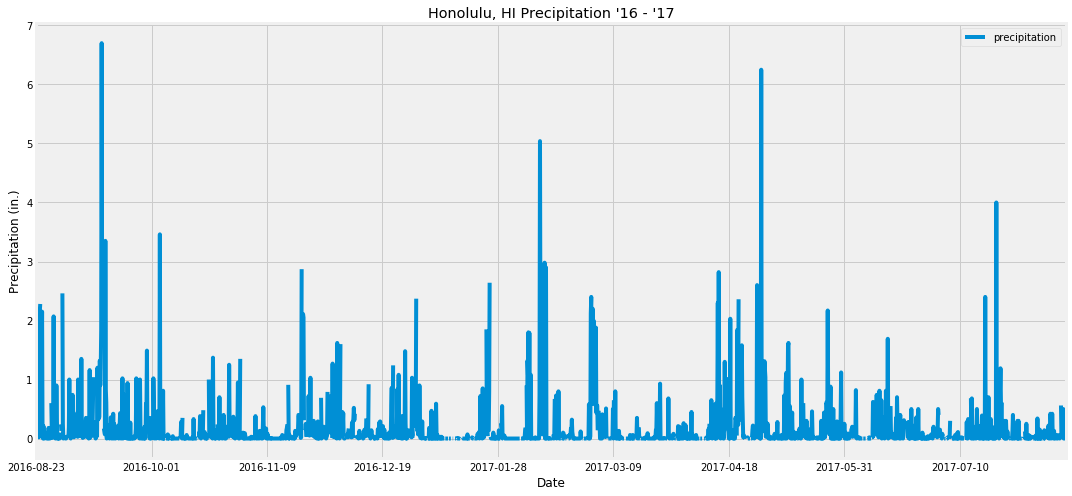

In [36]:
#plot data
fig, ax = plt.subplots(figsize = (15, 7))
precip_df.plot(ax = ax)

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Honolulu, HI Precipitation '16 - '17")

plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [19]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).distinct().count()
station_count

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_counts:
    print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [21]:
most_active_station = 'USC00519281'
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
yearly_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

#save as a data frame
yearly_temps_df = pd.DataFrame(yearly_temps, columns = ['date', 'temperature'])
yearly_temps_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-01-04', '2017-01-18')

print(f"Lowest Temperature: {trip_temps[0][0]} Fahrenheit")
print(f"Average Temperature: {round(trip_temps[0][1], 2)} Fahrenheit")
print(f"Highest Temperature: {trip_temps[0][2]} Fahrenheit")

Lowest Temperature: 60.0 Fahrenheit
Average Temperature: 69.26 Fahrenheit
Highest Temperature: 81.0 Fahrenheit


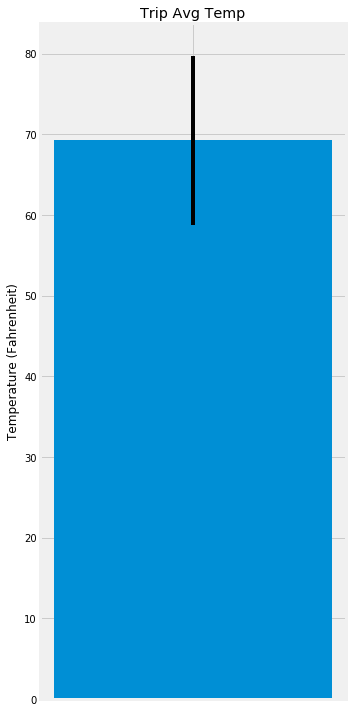

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
pk_to_pk = trip_temps[0][2] - trip_temps[0][0]
avg_temp = trip_temps[0][1]

#plot figure
fig, ax = plt.subplots(figsize = (5, 10))

ax.bar(1, avg_temp, yerr = pk_to_pk/2, width = 0.4)

#set labels
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temperature (Fahrenheit)')
plt.tight_layout()
plt.show()

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

yearly_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

#load into a dataframe
yearly_rainfall_df = pd.DataFrame(yearly_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation (in.)'])

yearly_rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044819


## Optional Challenge Assignment

In [1]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    


In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


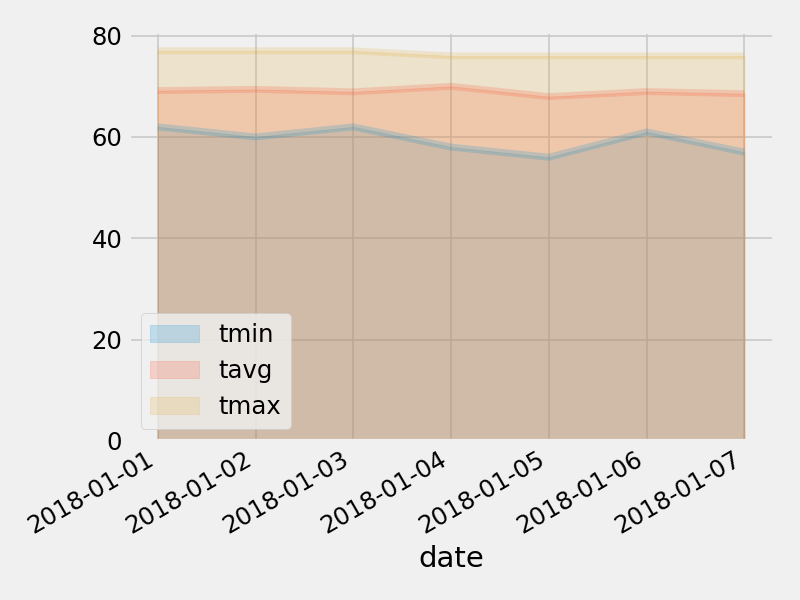

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
